## Constraint Active Search for Multiobjective Experimental Design

In this tutorial we show how to implement the Expected Coverage Improvement (ECI) [1] acquisition function in BoTorch. For a number of outcome constraints, ECI tries to efficiently discover the feasible region and simultaneously sample diverse feasible configurations. Given a user-specified punchout radius $r$, we center a sphere with that radius around each evaluated configuration. The total coverage is now given by the volume of the union of these sphere intersected with the feasible region; see the paper and, in particular, Figure 2 for a full description of how ECI works.

By design, ECI prefers candidates that are in unexplored regions since the candidate's corresponding sphere won't intersect with the spheres around the previously evaluated configurations. On the other hand, ECI also prefers configurations that are likely to satisfy the constraints and to give an improvement in the total coverage. This results in an exploitation-exploration trade-off similar to other acquisition functions.

ECI may be estimated using the following equation:
$$
\text{ECI}(x) = \sum_{x' \in \mathbb{N}(x) \setminus \mathbb{N}_{r}(X)} p(Z(x') = 1 \;|\; \mathcal{D}_t).
$$

where $\mathbb{N}(x) \setminus \mathbb{N}_{r}(X)$ a set of points generated via Monte Carlo to be inside a sphere of radius $r$ around $x$, but sufficiently far from the set of known evaluations $X$ (where sufficiently far is defined by the punchout radius $r$). The function $p(Z(x') = 1 \;|\; \mathcal{D}_t)$ is the probability that the GP at $x'$ satisfies a user-specified threshold value, or threshold values in the case of multiple objective functions. 

[1]: [Malkomes et al., Beyond the Pareto Efficient Frontier: Constraint Active Search for Multiobjective Experimental Design, Proceedings of the 38th International Conference on Machine Learning, 2021](http://proceedings.mlr.press/v139/malkomes21a/malkomes21a.pdf).

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os

import torch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_mll
from botorch.models import ModelListGP, SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import average_over_ensemble_models, t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine


SMOKE_TEST = os.environ.get("SMOKE_TEST")


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [3]:
tkwargs = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

To start, we need to be able to sample points in $\mathbb{N}(x) \setminus \mathbb{N}_{r}(X)$. We can generate a pool of points and use standard rejection sampling to do so, but this leads to an acquisition function that isn't immediately differentiable; rejection sampling is essentially providing either a binary weight of either 0 or 1 to each point in the sample pool, which is not a differentiable function. 


In order to make the acquisition function differentiable, we rely on a differentiable approximation of this binary weight function. For example, `smooth_box_mask` is a continuous differentiable approximation of $a < x < b$ (see the plot below for a visualization). A larger value of eps will make the sigmoid less steep and result in a smoother (and easier to optimize) but less accurate acquisition function. 

In [4]:
def smooth_mask(x, a, eps=2e-3):
    """Returns 0ish for x < a and 1ish for x > a"""
    return torch.nn.Sigmoid()((x - a) / eps)


def smooth_box_mask(x, a, b, eps=2e-3):
    """Returns 1ish for a < x < b and 0ish otherwise"""
    return smooth_mask(x, a, eps) - smooth_mask(x, b, eps)

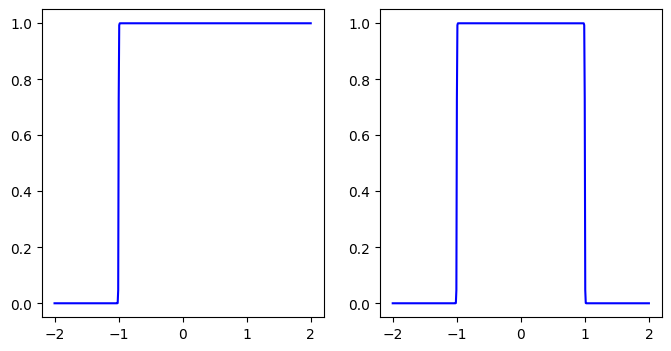

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline


x = torch.linspace(-2, 2, 500, **tkwargs)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x.cpu(), smooth_mask(x, -1).cpu(), "b")
ax[1].plot(x.cpu(), smooth_box_mask(x, -1, 1).cpu(), "b")
plt.show()

## Implementation of ECI

Once we have defined our smooth mask functions, we can compute a differentiable approximation of ECI in a straightforward manner using Monte Carlo (MC). We use the popular variance reduction technique of Common random numbers (CRN).

We first use a low discrepancy sequence to generate a set of base samples. We integrate (sum) over these base samples to approximate the ECI acquisition function. Fixing these base samples makes the method deterministic and by using the smooth masks defined earlier, we can filter out infeasible points while still having a differentiable acquisition function.

This implementation assumes that the GP models for the different outputs are independent and that each constraints only affects one output (simple box-constraints like f(x) <= 0.5).

In [6]:
class ExpectedCoverageImprovement(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        constraints,
        punchout_radius,
        bounds,
        num_samples=128,
        **kwargs,
    ):
        """Expected Coverage Improvement (q=1 required, analytic)

        Right now, we assume that all the models in the ModelListGP have
        the same training inputs.

        Args:
            model: A ModelListGP object containing models matching the corresponding constraints.
                All models are assumed to have the same training data.
            constraints: List containing 2-tuples with (direction, value), e.g.,
                [('gt', 3), ('lt', 4)]. It is necessary that
                len(constraints) == model.num_outputs.
            punchout_radius: Positive value defining the desired minimum distance between points
            bounds: torch.tensor whose first row is the lower bounds and second row is the upper bounds
            num_samples: Number of samples for MC integration
        """
        super().__init__(model=model, objective=IdentityMCObjective(), **kwargs)
        assert len(constraints) == model.num_outputs
        assert all(direction in ("gt", "lt") for direction, _ in constraints)
        assert punchout_radius > 0
        self.constraints = constraints
        self.punchout_radius = punchout_radius
        self.bounds = bounds
        self.base_points = self.train_inputs
        self.ball_of_points = self._generate_ball_of_points(
            num_samples=num_samples,
            radius=punchout_radius,
            device=bounds.device,
            dtype=bounds.dtype,
        )
        self._thresholds = torch.tensor(
            [threshold for _, threshold in self.constraints]
        ).to(bounds)
        assert (
            all(ub > lb for lb, ub in self.bounds.T) and len(self.bounds.T) == self.dim
        )

    @property
    def num_outputs(self):
        return self.model.num_outputs

    @property
    def dim(self):
        return self.train_inputs.shape[-1]

    @property
    def train_inputs(self):
        return self.model.models[0].train_inputs[0]

    def _generate_ball_of_points(
        self, num_samples, radius, device=None, dtype=torch.double
    ):
        """Creates a ball of points to be used for MC."""
        tkwargs = {"device": device, "dtype": dtype}
        z = sample_hypersphere(d=self.dim, n=num_samples, qmc=True, **tkwargs)
        r = torch.rand(num_samples, 1, **tkwargs) ** (1 / self.dim)
        return radius * r * z

    def _get_base_point_mask(self, X):
        distance_matrix = self.model.models[0].covar_module.covar_dist(
            X, self.base_points
        )
        return smooth_mask(distance_matrix, self.punchout_radius)

    def _estimate_probabilities_of_satisfaction_at_points(self, points):
        """Estimate the probability of satisfying the given constraints."""
        posterior = self.model.posterior(X=points)
        mus, sigma2s = posterior.mean, posterior.variance
        dist = torch.distributions.normal.Normal(mus, sigma2s.sqrt())
        norm_cdf = dist.cdf(self._thresholds)
        probs = torch.ones(points.shape[:-1]).to(points)
        for i, (direction, _) in enumerate(self.constraints):
            probs = probs * (
                norm_cdf[..., i] if direction == "lt" else 1 - norm_cdf[..., i]
            )
        return probs

    @t_batch_mode_transform(expected_q=1)
    @average_over_ensemble_models
    def forward(self, X):
        """Evaluate Expected Improvement on the candidate set X."""
        ball_around_X = self.ball_of_points + X
        domain_mask = smooth_box_mask(
            ball_around_X, self.bounds[0, :], self.bounds[1, :]
        ).prod(dim=-1)
        num_points_in_integral = domain_mask.sum(dim=-1)
        base_point_mask = self._get_base_point_mask(ball_around_X).prod(dim=-1)
        prob = self._estimate_probabilities_of_satisfaction_at_points(ball_around_X)
        masked_prob = prob * domain_mask * base_point_mask
        y = masked_prob.sum(dim=-1) / num_points_in_integral
        return y

In [7]:
def get_and_fit_gp(X, Y):
    """Simple method for creating a GP with one output dimension.

    X is assumed to be in [0, 1]^d.
    """
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))  # Noise-free
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model=gp, likelihood=gp.likelihood)
    fit_gpytorch_mll(mll)
    return gp

### Simple 1D function

To sanity check things, we consider the ECI acquisition function on a one-dimensional toy problem. 

In [8]:
def yf(x):
    return (1 - torch.exp(-4 * (x[:, 0] - 0.4) ** 2)).unsqueeze(-1)


x = torch.tensor([0, 0.15, 0.25, 0.4, 0.8, 1.0], **tkwargs).unsqueeze(-1)
y = yf(x)
xx = torch.linspace(0, 1, 200, **tkwargs).unsqueeze(-1)
yy = yf(xx)

### Create an ECI acquisition function
Our implementation assumes that the GP is passed in as a `ModelListGP` and that the GPs match the corresponding constraints. As an example, assume we have two outputs, represented by `gp1` and `gp2` and two constraints corresponding to output 1 and a third constraint corresponding to output 2. In that case we will create a model list GP as `ModelListGP(gp1, gp1, gp2)` so they match the constraints.

In [9]:
gp = get_and_fit_gp(x, y)
model_list_gp = ModelListGP(gp, gp)
constraints = [("lt", 0.3), ("gt", 0.05)]
punchout_radius = 0.03
bounds = torch.tensor([(0, 1)], **tkwargs).T
eci = ExpectedCoverageImprovement(
    model=model_list_gp,
    constraints=constraints,
    punchout_radius=punchout_radius,
    bounds=bounds,
    num_samples=128 if not SMOKE_TEST else 4,
)

### Optimize the acquisition function

In [10]:
best_candidate, best_eci_value = optimize_acqf(
    acq_function=eci,
    bounds=torch.tensor([[0.0], [1.0]], **tkwargs),
    q=1,
    num_restarts=10,
    raw_samples=20,  # use a small number here to make sure the optimization works
)
print(f"Best candidate: {best_candidate.cpu().item():.3f}")

Best candidate: 0.636


### Plot the GP and the ECI acquisition function
The left plot shows the GP posterior with a 95% confidence interval. The two horizontal lines indicate the feasible region defined by $0.05 \leq f(x) \leq 0.3$. These inequality constraints implicitly define a feasible region, outside which ECI has value zero. 

We can see in the right plot that ECI indeed has a nonzero value inside the feasible region and a zero value outside. We also optimize the acquisition function and mark its argmax with black star; the argmax is around $x=0.62$. This is reasonable because ECI seeks to select diverse points within the feasible region. $x=0.62$ is far away from other evaluations and thus has the highest diversity. 

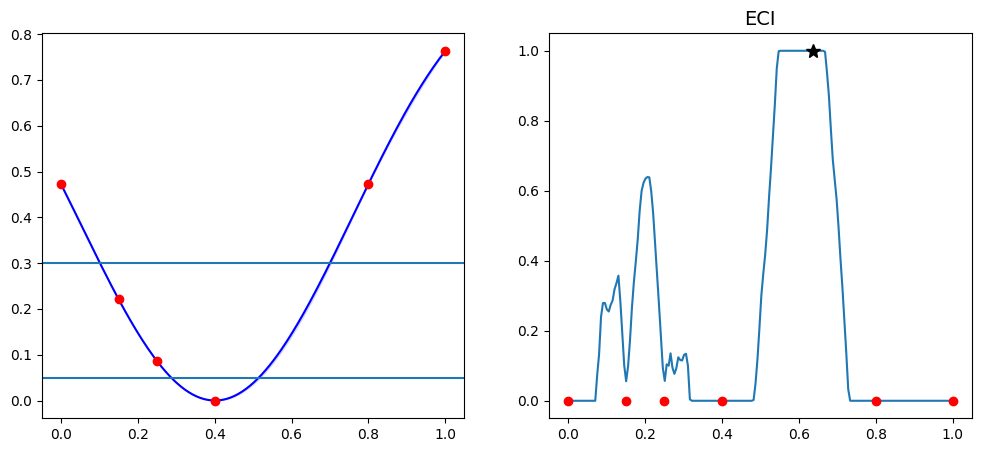

In [11]:
with torch.no_grad():
    posterior = gp.posterior(X=xx.unsqueeze(1))
ymean, yvar = posterior.mean.squeeze(-1), posterior.variance.squeeze(-1)
eci_vals = eci(xx.unsqueeze(1))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax = axes[0]
ax.plot(xx[:, 0].cpu(), ymean[:, 0].cpu(), "b")
ax.fill_between(
    xx[:, 0].cpu(),
    ymean[:, 0].cpu() - 1.96 * yvar[:, 0].sqrt().cpu(),
    ymean[:, 0].cpu() + 1.96 * yvar[:, 0].sqrt().cpu(),
    alpha=0.1,
    color="b",
)
ax.plot(x[:, 0].cpu(), y[:, 0].cpu(), "or")
ax.axhline(0.05, 0, 1)
ax.axhline(0.3, 0, 1)

ax = axes[1]
ax.plot(xx[:, 0].cpu(), eci_vals.detach().cpu())
ax.plot(x[:, 0].cpu(), torch.zeros(len(x), **tkwargs).cpu(), "or")
ax.plot(best_candidate.cpu(), best_eci_value.cpu(), "*k", ms=10)
ax.set_title("ECI", fontsize=14)
plt.show()

## Full 2D CAS-loop 
This creates a simple function with two outputs that we will consider under the two constraints $f_1(x) \leq 0.75$ and $f_2(x) \geq 0.55$. In this particular example, the $f_1(x)$ and $f_2(x)$ are same function for simplicity. 

The CAS loop follows the prototypical BO loop: 
1. Given a surrogate model, maximize ECI to select the next evaluation x.
2. Observe f(x).
3. Update the surrogate model. 

In [12]:
def yf2d(x):
    v = torch.exp(-2 * (x[:, 0] - 0.3) ** 2 - 4 * (x[:, 1] - 0.6) ** 2)
    return torch.stack((v, v), dim=-1)


bounds = torch.tensor([[0, 0], [1, 1]], **tkwargs)
lb, ub = bounds
dim = len(lb)
constraints = [("lt", 0.75), ("gt", 0.55)]
punchout_radius = 0.1

### CAS loop using 5 initial Sobol points and 15 ECI iterations

In [13]:
num_init_points = 5
num_total_points = 15 if not SMOKE_TEST else 5

X = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
Y = yf2d(X)

while len(X) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    gp_models = [get_and_fit_gp(X, Y[:, i : i + 1]) for i in range(Y.shape[-1])]
    model_list_gp = ModelListGP(gp_models[0], gp_models[1])
    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=128 if not SMOKE_TEST else 4,
    )
    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10 if not SMOKE_TEST else 2,
        raw_samples=512 if not SMOKE_TEST else 4,
    )
    y_next = yf2d(x_next)
    X = torch.cat((X, x_next))
    Y = torch.cat((Y, y_next))

### Plot the selected points
We plot the feasible region and the points selected by ECI below. The feasible region is outlined with a black ring, and points selected by ECI are marked in green (feasible) and red (infeasible). By design, observe that ECI selects a diverse i.e., well-spaced set of points inside the feasible region. 

In [14]:
N1, N2 = 30, 30
Xplt, Yplt = torch.meshgrid(
    torch.linspace(0, 1, N1, **tkwargs), torch.linspace(0, 1, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
yplt = yf2d(xplt)
Zplt = torch.reshape(yplt[:, 0], (N1, N2))  # Since f1(x) = f2(x)

/opt/anaconda3/envs/botorch/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


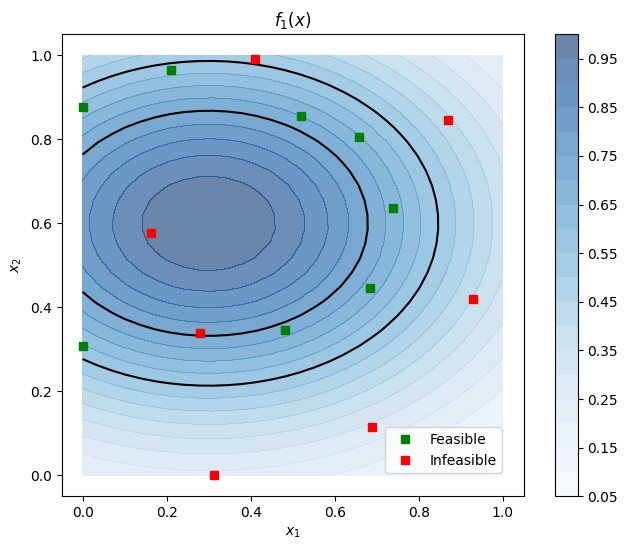

In [15]:
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)
    for model_index in range(X.shape[-1]):
        these_X = X[..., model_index]
        direction, value = constraints[model_index]
        successful[..., model_index] = (
            these_X < value if direction == "lt" else these_X > value
        )
    return successful


fig, ax = plt.subplots(figsize=(8, 6))
h1 = ax.contourf(Xplt.cpu().numpy(), Yplt.cpu().numpy(), Zplt.cpu().numpy(), 20, cmap="Blues", alpha=0.6)
fig.colorbar(h1)
ax.contour(Xplt.cpu().numpy(), Yplt.cpu().numpy(), Zplt.cpu().numpy(), [0.55, 0.75], colors="k")

feasible_inds = (
    identify_samples_which_satisfy_constraints(Y, constraints)
    .prod(dim=-1)
    .to(torch.bool)
)
ax.plot(X[feasible_inds, 0].cpu(), X[feasible_inds, 1].cpu(), "sg", label="Feasible")
ax.plot(
    X[~feasible_inds, 0].cpu(), X[~feasible_inds, 1].cpu(), "sr", label="Infeasible"
)

ax.legend(loc=[0.7, 0.05])
ax.set_title("$f_1(x)$")  # Recall that f1(x) = f2(x)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal", "box")
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
plt.show()